<pre>머신러닝 모델 개발한 파일(연구중)</pre>

<pre>개봉예정영화 데이터: 장르, 개봉시기, 상영시간, 출연, 감독, 등급, 국가
이중 장르, 출연, 감독, 국가를 데이터로 설정</pre>

In [1]:
import pandas as pd
import numpy as np

In [147]:
# title budget genres country main_charactor director vote_average vote_count
df = pd.concat([pd.read_csv('data/movie_genres_data.csv'), pd.read_csv('data/movie_data_ID.csv')], axis=1)
# heatmap의 상관관계 있는 장르만 사용해보자
# 모험, 애니메이션, 코미디, 드라마, 공포
#df = df.drop(['액션', '판타지', '가족', 'SF', '스릴러', '범죄', '미스터리', '음악', '역사', '전쟁', '로맨스', '다큐멘터리', 'TV 영화', '서부'], axis=1)

In [148]:
# 로지스틱 회귀 모델(sigmoid) : weight초기화, dropout, ReLU, batch nomalization
# 결과 : 흥행성공, 흥행 실패, 전체영화 의 평균 정확도
# 1. 데이터셋 준비하기
df.drop(['genres', 'country', 'vote_score', 'vote_count'], axis=1, inplace=True)
df.vote_weight = df.vote_weight.apply(lambda x: 1 if x >= 5 else 0)

print(df.budget.max())
print(df.charactor.max())
print(df.director.max())

380000000
3646905
3646897


In [149]:
df.budget = df.budget / df.budget.max()
df.charactor = df.charactor / df.charactor.max()
df.director = df.director / df.director.max()

In [150]:
df.to_csv('data/movie_data_ML_op.csv', index=False)

In [151]:
df.drop(['title'], axis=1, inplace=True)
#df.drop(['budget'], axis=1, inplace=True)

In [152]:
df.head(1)

,액션,모험,판타지,가족,애니메이션,코미디,SF,드라마,공포,스릴러,...,역사,TV 영화,전쟁,로맨스,다큐멘터리,서부,budget,charactor,director,vote_weight
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.657895,0.001068,0.015337,1


In [3]:
df_one = pd.read_csv('data/movie_data_ID_One.csv')
df_one.drop(['title', 'vote_score', 'vote_count'], axis=1, inplace=True)

In [5]:
df_one.head(5)

,budget,genres,country,charactor,director,vote_weight
0,250000000,28,1,3894,55934,5.482992
1,165000000,12,1,18997,930707,5.972419
2,85000000,10751,1,124747,8023,5.695402
3,170000000,28,1,996701,86270,6.379786
4,18800000,27,1,1530558,55499,6.110784


In [2]:
df_one.budget = df_one.budget / df_one.budget.max()
df_one.charactor = df_one.charactor / df_one.charactor.max()
df_one.director = df_one.director / df_one.director.max()
df_one.genres = df_one.genres / df_one.genres.max()
df_one.country = df_one.country / df_one.country.max()

In [215]:
df_one.vote_weight = df_one.vote_weight.apply(lambda x: 1 if x >= 5 else 0)

In [216]:
df_one.head(10)

,budget,genres,country,charactor,director,vote_weight
0,0.657895,0.002600,0.013333,0.001068,0.015337,1
1,0.434211,0.001114,0.013333,0.005209,0.255205,1
2,0.223684,0.998236,0.013333,0.034206,0.002200,1
3,0.447368,0.002600,0.013333,0.273301,0.023656,1
4,0.049474,0.002507,0.013333,0.419687,0.015218,1
5,0.526316,0.001300,0.013333,0.151044,0.002090,1
6,0.526316,0.001486,0.013333,0.020480,0.002174,1
7,0.526316,0.002600,0.013333,0.004614,0.005284,1
8,0.223684,0.965831,0.026667,0.000009,0.001700,1
9,0.526316,0.002600,0.013333,0.138668,0.354821,1


In [217]:
X = np.array(df_one)
print(X.shape)


(5128, 6)


In [218]:
y = X[:, 5:]
X = X[:, :-1]
print(X.shape)
print(y.shape)

(5128, 5)
(5128, 1)


In [219]:
# y_train : 흥행했는지(1) 안했는지(0)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_val = X_test[:513]
y_val = y_test[:513]

In [220]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(4615, 5)
(4615, 1)
(513, 5)
(513, 1)
(513, 5)
(513, 1)


- 모델 구성 및 분석

In [212]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams.update({'text.color': "black",
                    'axes.labelcolor': "white",
                     'xtick.color': "white",
                     'ytick.color': "white"
                     })

Epoch 1/100
145/145 [==============================] - 1s 4ms/step - loss: 0.6611 - accuracy: 0.5922 - val_loss: 0.6512 - val_accuracy: 0.6062
Epoch 2/100
145/145 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6206 - val_loss: 0.6530 - val_accuracy: 0.5984
Epoch 3/100
145/145 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6284 - val_loss: 0.6492 - val_accuracy: 0.5984
Epoch 4/100
145/145 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6308 - val_loss: 0.6500 - val_accuracy: 0.5926
Epoch 5/100
145/145 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6288 - val_loss: 0.6487 - val_accuracy: 0.6062
Epoch 6/100
145/145 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.6260 - val_loss: 0.6471 - val_accuracy: 0.6101
Epoch 7/100
145/145 [==============================] - 1s 4ms/step - loss: 0.6313 - accuracy: 0.6254 - val_loss: 0.6465 - val_accuracy: 0.6082

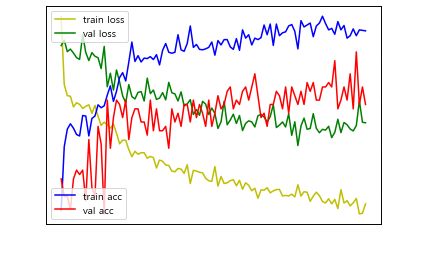

In [241]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
import tensorflow as tf
model = Sequential()
# 1. 과적합 : train acc 85%, test acc 65% => Node수와 Hidden Layer수를 줄여야함
#model.add(Dense(64, activation='relu', input_dim=22))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(64, activation='relu'))

# 2. Dense의 한계치 : test acc 68% => 다른 모델을 사용해야함, L2 Regularization : test acc 69%
#model.add(Dense(32, activation='relu', input_dim=8))
#model.add(Dense(1, activation='sigmoid'))

#tf.keras.regularizers.L2(
#    l2=0.01
#)
# Dropout 68.5%
model.add(Dense(128, activation='relu', input_dim=5))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu'))
#model.add(Dense(10, kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(X_train, y_train, epochs=100, batch_size=32,
                 validation_data=(X_val, y_val))

loss_and_metrics = model.evaluate(X_test, y_test, batch_size=32)
print('손실 :', loss_and_metrics[0])
print('정확도 :', loss_and_metrics[1] * 100, '%')
print("-" * 20)

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'r', label='val acc')

loss_ax.set_xlabel('epoch')

loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

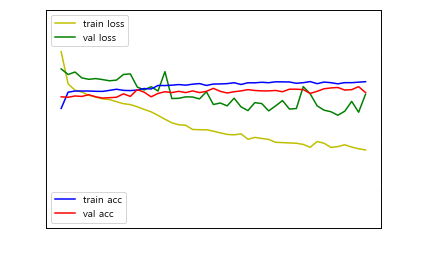

In [238]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'r', label='val acc')

loss_ax.set_xlabel('epoch')

loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
acc_ax.set_ylim(0, 1)
loss_ax.set_ylim(0.55, 0.7)
plt.show()

In [144]:
yhat = model.predict(X_test)
for i in range(30):
    print(1 if yhat[i] > 0.5 else 0, end=" ")
print()
for i in y_test[:30]:
    print(int(*i), end=" ")

33/33 [==============================] - 0s 1ms/step
1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 
1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 

In [126]:
model.save('model/Dense_Dropout_nobudget.h5')